In [1]:
%matplotlib inline

In [2]:
import roms_tools as rt
from pathlib import Path
import datetime as dt
from dask.diagnostics import ProgressBar
rt.__version__

'2.2.1'

In [3]:
outdir = Path("input_datasets_netcdf")
partdir = Path("input_netcdf_parted")
yamldir = Path("input_datasets_yaml")

outdir.mkdir(exist_ok=True,parents=True)
partdir.mkdir(exist_ok=True,parents=True)
yamldir.mkdir(exist_ok=True,parents=True)

start_time = dt.datetime(2012, 1, 1, 0, 0, 0)
end_time   = dt.datetime(2012, 2, 1, 0, 0, 0)

In [4]:
import os

In [5]:
import os
if os.environ.get("LMOD_SYSHOST") == "perlmutter":
    glorys_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/GLORYS/NA/2012/")
    era5_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/ERA5/NA/2012/")
    cesm_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/CESM_REGRIDDED/")
    tpxo_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/TPXO/")
else: # If you're not on perlmutter, we'll assume you've put your roms-tools datasets in ~/Code/roms_tools_datasets:
    datadir = Path("~/Code/roms_tools_datasets").expanduser()
    glorys_datadir = datadir / "GLORYS/"
    era5_datadir = datadir
    cesm_datadir = datadir
    tpxo_datadir = datadir

In [6]:
rm {outdir}/*.nc

rm: cannot remove 'input_datasets_netcdf/*.nc': No such file or directory


In [7]:
rm {partdir}/*.nc

rm: cannot remove 'input_netcdf_parted/*.nc': No such file or directory


In [8]:
rm {yamldir}/*.yaml

rm: cannot remove 'input_datasets_yaml/*.yaml': No such file or directory


In [9]:
NP_XI = 3
NP_ETA = 3

# Make grid

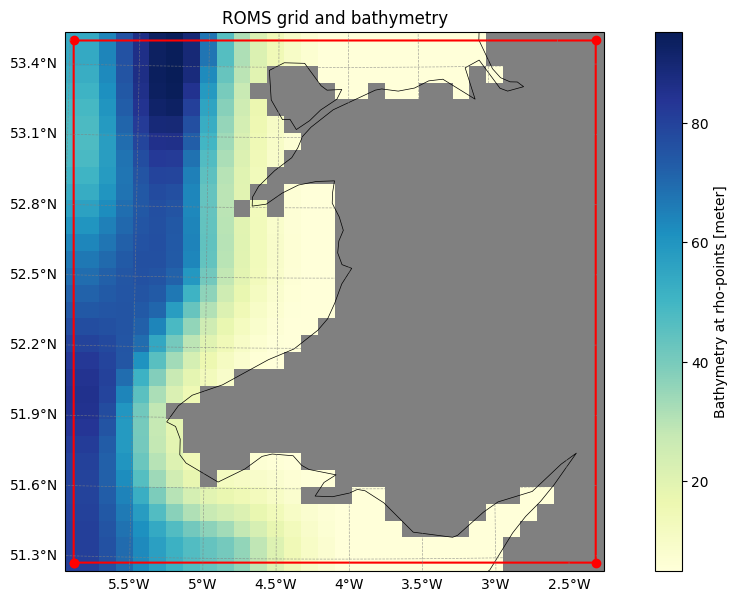

In [10]:
roms_grd = rt.Grid(nx=30,
                   ny = 30,
                   size_x = 240,
                   size_y = 240,
                   N = 20,
                   rot = 0,
                   center_lon = -4.1,
                   center_lat = 52.4)

roms_grd.plot(bathymetry=True)


# Make tides

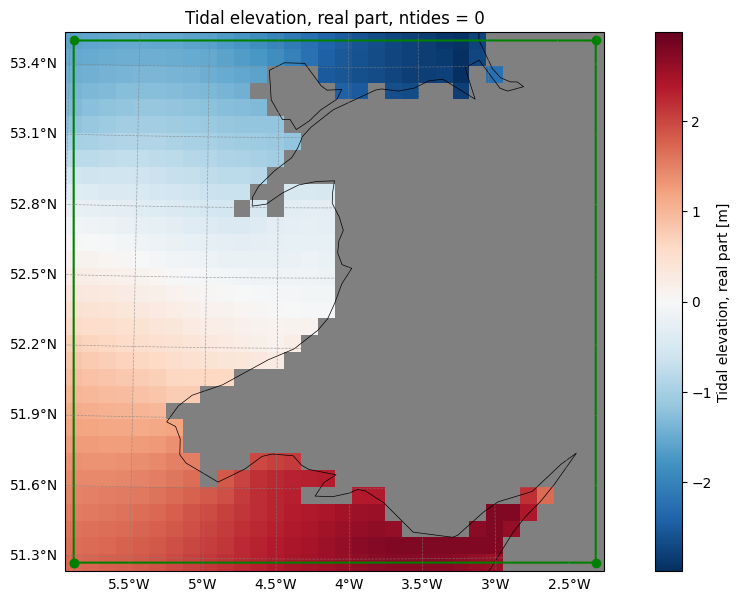

In [11]:
roms_tides = rt.TidalForcing(grid=roms_grd,
                             source = {'name':'TPXO','path': tpxo_datadir / 'tpxo9.v2a.nc'},
                             ntides = 14)
roms_tides.plot("ssh_Re", ntides=0)


# Atmospheric forcing (physics)

In [12]:
# %%time
roms_frc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_datadir/"ERA5_2012-01.nc"},
    correct_radiation=True,
    use_coarse_grid=False,
    type="physics",  # "physics" or "bgc"; default is "physics"
)

WARNING - No records found at or after the end_time.


# Atmospheric forcing (BGC)

In [13]:
# %%time
roms_frc_bgc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_datadir/"CESM-surface_lowres_regridded.nc"},
    type="bgc",
)

# Initial conditions

INFO - Selected time entry closest to the specified start_time (2012-01-01 00:00:00) within the range [2012-01-01 00:00:00, 2012-01-02 00:00:00]: ['2012-01-01T12:00:00.000000000']


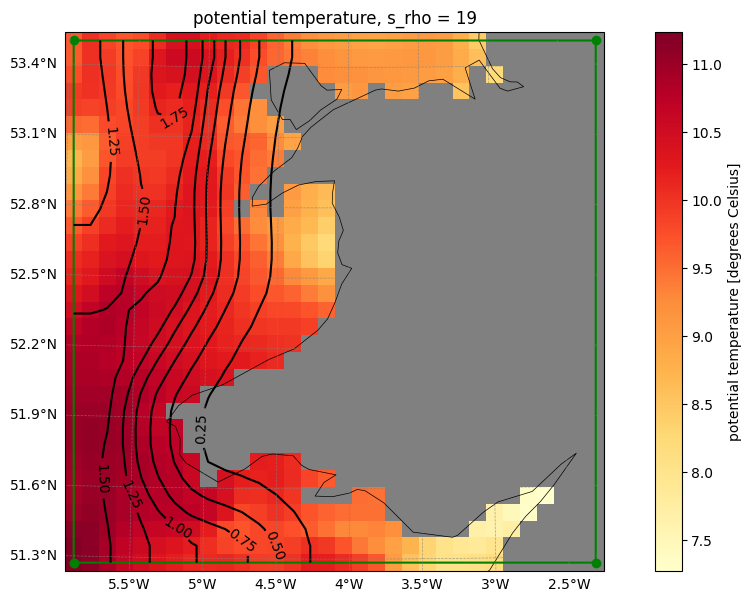

In [14]:
# %%time
ini_time=dt.datetime(2012,1,1)
roms_ini = rt.InitialConditions(
    grid=roms_grd,
    ini_time=ini_time,
    source={"name" : "GLORYS",
                    "path" : glorys_datadir/"mercatorglorys12v1_gl12_mean_20120101.nc"},
    bgc_source={"name": "CESM_REGRIDDED",
                "path": cesm_datadir/"CESM-climatology_lowres_regridded.nc",
                "climatology": True,
    },
)
roms_ini.plot("temp", s=-1, depth_contours=True)


# Boundary conditions

In [15]:
roms_bry = rt.BoundaryForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_datadir/"mercatorglorys*.nc"},
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True
)

WARNING - No records found at or before the start_time.


In [16]:

roms_bry_bgc = rt.BoundaryForcing(
    grid = roms_grd,
    start_time = start_time,
    end_time = end_time,
    source={"name": "CESM_REGRIDDED", 
            "path": cesm_datadir/"CESM-climatology_lowres_regridded.nc", 
            "climatology": True},
    type="bgc",
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True    
)
# Save yaml



# River forcing

In [17]:
roms_riv_frc = rt.RiverForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    convert_to_climatology="if_any_missing",  # "never", "always", or "if_any_missing" (default)
)


INFO - Compute climatology for river forcing.


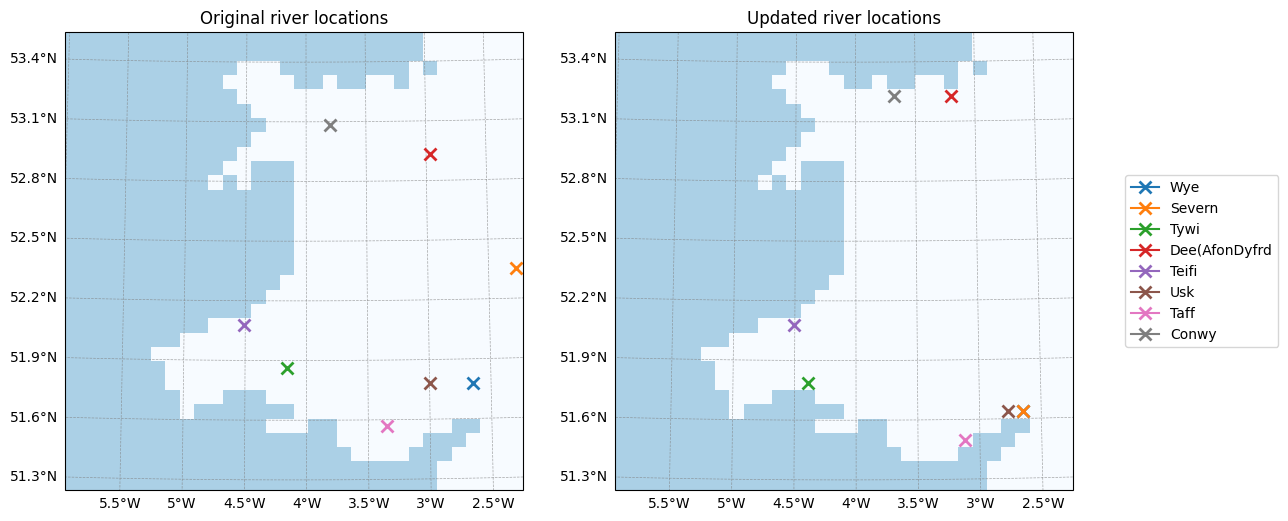

In [18]:
roms_riv_frc.plot_locations()

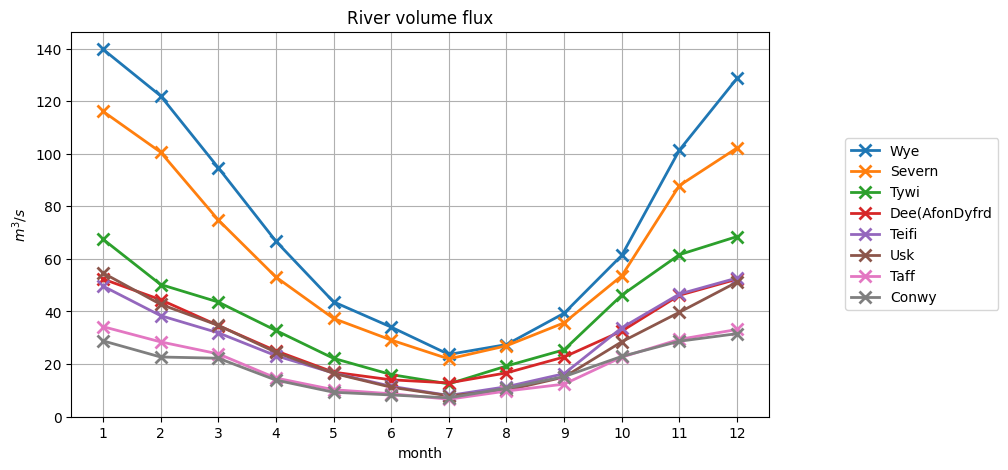

In [19]:
roms_riv_frc.plot("river_volume")

# Save all to yaml:

In [20]:
roms_grd.to_yaml(yamldir/"roms_grd.yaml")
roms_tides.to_yaml(yamldir/"roms_tides.yaml")
roms_frc.to_yaml(yamldir/'roms_frc.yaml')
roms_frc_bgc.to_yaml(yamldir/'roms_frc_bgc.yaml')
roms_ini.to_yaml(yamldir/'roms_ini.yaml')
roms_bry.to_yaml(yamldir/"roms_bry.yaml")
roms_bry_bgc.to_yaml(yamldir/"roms_bry_bgc.yaml")
roms_riv_frc.to_yaml(yamldir/"roms_riv_frc.yaml")

# Save all to netcdf

In [ ]:
with ProgressBar():
    roms_grd.save(outdir /"roms_grd")
    roms_tides.save(outdir/'roms_tides.nc')
    roms_frc.save(outdir/'roms_frc')
    roms_frc_bgc.save(filepath=outdir/'roms_frc_bgc')
    roms_ini.save(outdir/"roms_ini.nc")
    roms_bry.save(f"{outdir}/roms_bry") #no .nc again
    roms_bry_bgc.save(f"{outdir}/roms_bry_bgc")    
    roms_riv_frc.save(filepath=outdir/"roms_riv_frc.nc", filepath_grid=outdir/"roms_grd.nc")


# Save all to partitioned netcdf

In [23]:
with ProgressBar():
    roms_grd.save(partdir /"roms_grd", np_xi=NP_XI, np_eta=NP_ETA)
    roms_tides.save(partdir/'roms_tides.nc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_frc.save(partdir/'roms_frc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_frc_bgc.save(filepath=partdir/'roms_frc_bgc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_ini.save(partdir/"roms_ini.nc",np_xi=NP_XI,np_eta=NP_ETA)
    roms_bry.save(f"{partdir}/roms_bry",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again
    roms_bry_bgc.save(f"{partdir}/roms_bry_bgc",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again
    roms_riv_frc.save(filepath=partdir/"roms_riv_frc.nc", filepath_grid=partdir/"roms_grd.nc",np_xi=NP_XI,np_eta=NP_ETA)